# **Step-1 Preprocessing**

## **Importing libraries**

In [ ]:
!pip install scikit-optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFE
import time
import warnings
warnings.filterwarnings("ignore")

## **Import dataset**

In [ ]:
dataset = pd.read_csv('/content/data.CSV')
print(dataset.head())

       Lat  Lat dir      Long  Long dir        Date      Time
0  9.570306       N  78.106903        E  30-04-2024  08:29:11
1  0.000000     NaN   0.000000      NaN  30-04-2024  08:29:30
2  9.570318       N  78.106887        E  30-04-2024  08:29:31
3  9.570319       N  78.106887        E  30-04-2024  08:29:32
4  9.570319       N  78.106887        E  30-04-2024  08:29:33


## **Handling missing values and feature creation**

In [ ]:
# Handle missing values for Lat and Long columns
dataset['Lat '] = dataset['Lat '].replace(0, np.nan)
dataset['Long '] = dataset['Long '].replace(0, np.nan)
dataset['Lat '].ffill(inplace=True)
dataset['Long '].ffill(inplace=True)
dataset['Lat dir'].ffill(inplace=True)
dataset['Long dir'].ffill(inplace=True)

# Handle categorical features
dataset['Latdir_N'] = dataset['Lat dir'].apply(lambda x: 1 if x == 'N' else 0)
dataset['Latdir_S'] = dataset['Lat dir'].apply(lambda x: 1 if x == 'S' else 0)
dataset['Longdir_E'] = dataset['Long dir'].apply(lambda x: 1 if x == 'E' else 0)
dataset['Longdir_W'] = dataset['Long dir'].apply(lambda x: 1 if x == 'W' else 0)

# Handle missing values for Date and Time columns
dataset['Date'] = dataset['Date'].replace('-', np.nan)
dataset['Time'] = dataset['Time'].replace('-', np.nan)
dataset.dropna(subset=['Date', 'Time'], inplace=True)
dataset = dataset[~((dataset['Date'] == '0/0/0') & (dataset['Time'] == '0:0:0'))]

# Format Date and Time columns
dataset['Date'] = pd.to_datetime(dataset['Date'], errors='coerce')
dataset['Time'] = pd.to_timedelta(dataset['Time'], errors='coerce')

# Check for any remaining NaNs
if dataset.isnull().sum().any():
    print("Warning: There are still missing values in the dataset.")
    print(dataset.isnull().sum())

# Create additional features
reference_date = pd.to_datetime('1900-01-01')
dataset['Days_from_ref'] = (dataset['Date'] - reference_date).dt.days
dataset['Seconds_from_midnight'] = dataset['Time'].dt.total_seconds()
dataset['HourOfDay'] = dataset['Seconds_from_midnight'] // 3600

# Create time period features
dataset['Morning'] = ((dataset['HourOfDay'] >= 6) & (dataset['HourOfDay'] < 12)).astype(int)
dataset['Afternoon'] = ((dataset['HourOfDay'] >= 12) & (dataset['HourOfDay'] < 18)).astype(int)
dataset['Evening'] = ((dataset['HourOfDay'] >= 18) & (dataset['HourOfDay'] < 21)).astype(int)
dataset['Night'] = ((dataset['HourOfDay'] >= 21) | (dataset['HourOfDay'] < 6)).astype(int)

# Create interaction term and sinusoidal transformations
dataset['HourDayInteraction'] = dataset['HourOfDay'] * dataset['Date'].dt.dayofweek
dataset['Time_sin'] = np.sin(2 * np.pi * dataset['Seconds_from_midnight'] / 86400)
dataset['Time_cos'] = np.cos(2 * np.pi * dataset['Seconds_from_midnight'] / 86400)
dataset['Interaction_Seconds_Days'] = dataset['Seconds_from_midnight'] * dataset['Days_from_ref']

# Day of the week
day_of_week = dataset['Date'].dt.dayofweek
dataset['Monday'] = (day_of_week == 0).astype(int)
dataset['Tuesday'] = (day_of_week == 1).astype(int)
dataset['Wednesday'] = (day_of_week == 2).astype(int)
dataset['Thursday'] = (day_of_week == 3).astype(int)
dataset['Friday'] = (day_of_week == 4).astype(int)
dataset['Saturday'] = (day_of_week == 5).astype(int)
dataset['Sunday'] = (day_of_week == 6).astype(int)
dataset['Isweekend'] =(day_of_week == 5).astype(int)
dataset['Isweekend'] =(day_of_week == 6).astype(int)

# Extract features and target variables
X = dataset[['Interaction_Seconds_Days', 'Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos']].values
y = dataset[['Lat ', 'Long ', 'Latdir_N', 'Latdir_S', 'Longdir_E', 'Longdir_W']].values

# Apply log transformation to all numeric columns in X and y
X = np.log1p(X)
y = np.log1p(y)

# Check shapes of X and y
print("\nShape of X:", X.shape)
print("\nX", X[:5])
print("Shape of y:", y.shape)
print("\ny", y[:5])



Shape of X: (4791, 18)

X [[21.05064032 10.72350965 10.32718543  0.          0.69314718  0.
   0.          0.          0.          0.          0.          0.69314718
   0.          0.          0.          2.19722458  0.58529331 -0.93122812]
 [21.05126204 10.72350965 10.32780713  0.          0.69314718  0.
   0.          0.          0.          0.          0.          0.69314718
   0.          0.          0.          2.19722458  0.58482649 -0.93401985]
 [21.05129475 10.72350965 10.32783984  0.          0.69314718  0.
   0.          0.          0.          0.          0.          0.69314718
   0.          0.          0.          2.19722458  0.58480189 -0.93416692]
 [21.05132746 10.72350965 10.32787255  0.          0.69314718  0.
   0.          0.          0.          0.          0.          0.69314718
   0.          0.          0.          2.19722458  0.58477729 -0.934314  ]
 [21.05136017 10.72350965 10.32790525  0.          0.69314718  0.
   0.          0.          0.          0.      

## **Correlation matrix**

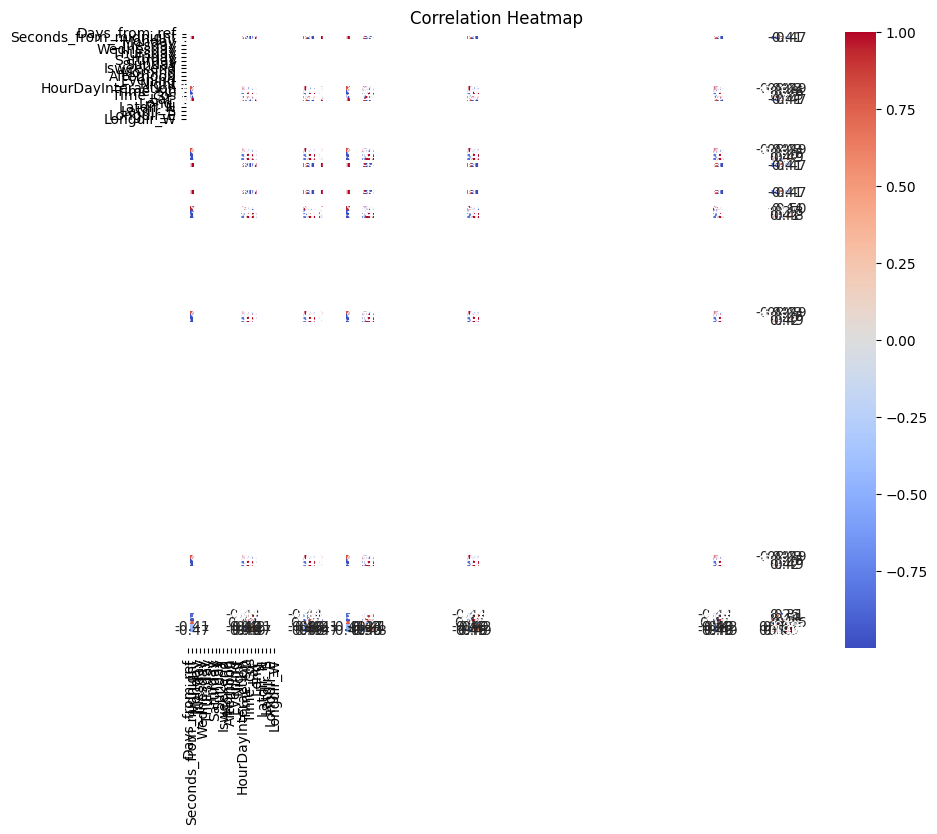

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correlation matrix function
def correlation_matrix(X, y):
    # Concatenate X and y to form a single matrix
    data = np.concatenate((X, y), axis=1)
    # Calculate the correlation matrix
    corr_matrix = np.corrcoef(data, rowvar=False)
    return corr_matrix

# Calculate the correlation matrix
corr_matrix = correlation_matrix(X, y)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=['Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos'] + ['Lat ', 'Long ', 'Latdir_N', 'Latdir_S', 'Longdir_E', 'Longdir_W'], yticklabels=['Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos'] + ['Lat ', 'Long ', 'Latdir_N', 'Latdir_S', 'Longdir_E', 'Longdir_W'])
plt.title('Correlation Heatmap')
plt.show()


Feature Importances from RandomForestRegressor:
                     Feature    Importance
17                  Time_cos  3.096417e-01
0   Interaction_Seconds_Days  2.698891e-01
16                  Time_sin  2.231027e-01
2      Seconds_from_midnight  1.973666e-01
15        HourDayInteraction  5.564945e-12
3                     Monday  0.000000e+00
4                    Tuesday  0.000000e+00
5                  Wednesday  0.000000e+00
6                   Thursday  0.000000e+00
7                     Friday  0.000000e+00
8                   Saturday  0.000000e+00
1              Days_from_ref  0.000000e+00
10                 Isweekend  0.000000e+00
11                   Morning  0.000000e+00
12                 Afternoon  0.000000e+00
13                   Evening  0.000000e+00
14                     Night  0.000000e+00
9                     Sunday  0.000000e+00


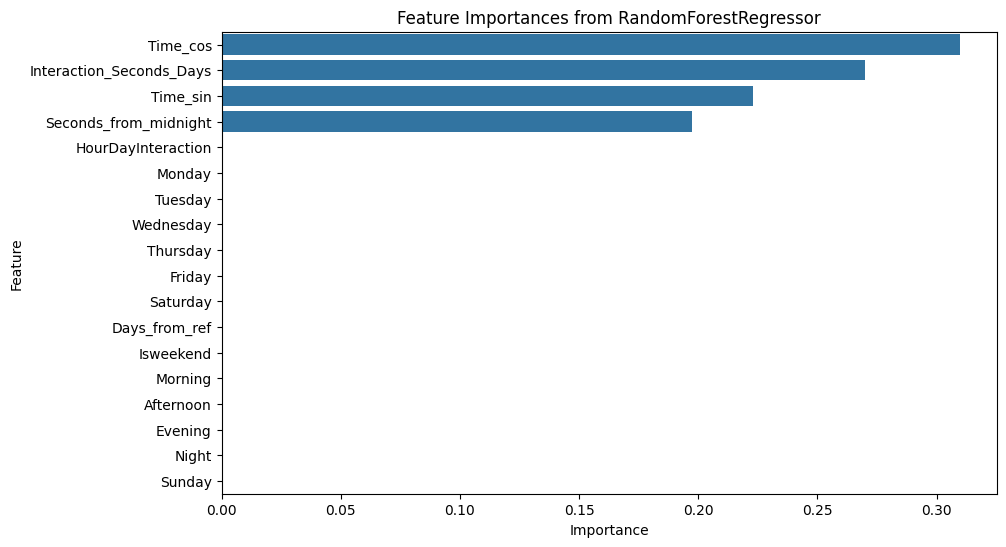

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Instantiate the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=1)

# Fit the model on the training data
rf_model.fit(X, y)

# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Define the feature names
features = ['Interaction_Seconds_Days', 'Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos']

# Create a DataFrame to store feature names and importances
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances from RandomForestRegressor:")
print(feature_importances_df)

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Feature Importances from XGBoost:
                     Feature  Importance
16                  Time_sin    0.688053
0   Interaction_Seconds_Days    0.311870
15        HourDayInteraction    0.000077
1              Days_from_ref    0.000000
14                     Night    0.000000
13                   Evening    0.000000
12                 Afternoon    0.000000
11                   Morning    0.000000
10                 Isweekend    0.000000
9                     Sunday    0.000000
8                   Saturday    0.000000
7                     Friday    0.000000
6                   Thursday    0.000000
5                  Wednesday    0.000000
4                    Tuesday    0.000000
3                     Monday    0.000000
2      Seconds_from_midnight    0.000000
17                  Time_cos    0.000000


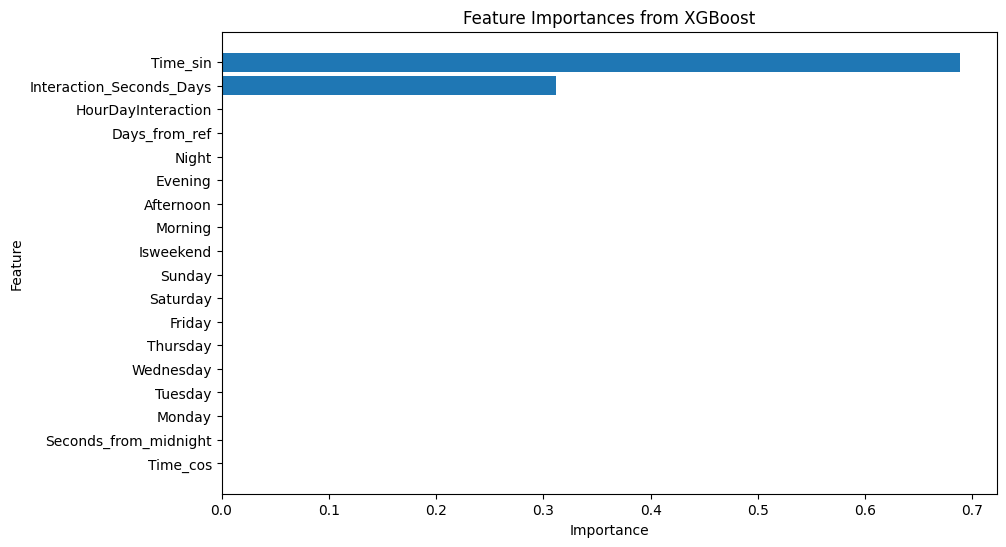

In [ ]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Train an XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
features = ['Interaction_Seconds_Days', 'Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos']
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances from XGBoost:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost')
plt.gca().invert_yaxis()
plt.show()


## **Train Test split**

In [ ]:
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Shape of X_train:", X_train_unscaled.shape)
print("Shape of X_test:", X_test_unscaled.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3832, 18)
Shape of X_test: (959, 18)
Shape of y_train: (3832, 6)
Shape of y_test: (959, 6)


## **Feature scaling**

In [ ]:
# Scaling the features (X)
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train_unscaled)
X_test = X_scaler.transform(X_test_unscaled)


# Scaling the target variables (y) using a separate scaler
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)
"""
print(X_train_unscaled)
print("\n")
print(X_train)

print("\n")
print("\n")
print(X_test_unscaled)
print("\n")
print(X_test)

print("\n")
print("\n")
print(y_train_unscaled)
print("\n")
print(y_train)

print("\n")
print("\n")
print(y_test_unscaled)
print("\n")
print(y_test)"""

'\nprint(X_train_unscaled)\nprint("\n")\nprint(X_train)\n\nprint("\n")\nprint("\n")\nprint(X_test_unscaled)\nprint("\n")\nprint(X_test)\n\nprint("\n")\nprint("\n")\nprint(y_train_unscaled)\nprint("\n")\nprint(y_train)\n\nprint("\n")\nprint("\n")\nprint(y_test_unscaled)\nprint("\n")\nprint(y_test)'

## **Model evaluation metrics**

In [ ]:
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def calculate_adjusted_r2(y_true, y_pred):
    n = len(y_true)
    k = 2
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

def print_evaluation_metrics(y_true, y_pred, model):
    mse = calculate_mse(y_true, y_pred)
    mae = calculate_mae(y_true, y_pred)
    rmse = calculate_rmse(y_true, y_pred)
    r2 = calculate_r2(y_true, y_pred)
    adjusted_r2 = calculate_adjusted_r2(y_true, y_pred)

    model_name = type(model).__name__
    print(f"Model: {model_name}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2): {r2}")
    print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")

def plot_predictions(y_train_true, y_train_pred, y_test_true, y_test_pred, model):
    plt.figure(figsize=(14, 6))

    # Training set
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_true, y_train_pred, alpha=0.5)
    plt.plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'r--')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title(f'Training Set: Predicted vs Actual\nModel: {type(model).__name__}')
    plt.grid(True)

    # Test set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_true, y_test_pred, alpha=0.5)
    plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title(f'Test Set: Predicted vs Actual\nModel: {type(model).__name__}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#print("Training Set Evaluation Metrics:")
#print_evaluation_metrics(y_train, y_train_pred, n_train, k)

#print("\nTest Set Evaluation Metrics:")
#print_evaluation_metrics(y_test, y_test_pred, n_test, k)

# plot_predictions(y_train, y_train_pred, y_test, y_test_pred, model)

# **Step 2 - Polynomial** **Regression Models**

## **Base model**


Training time: 141.02984046936035 seconds
Polynomial Regression:


Model: LinearRegression
Mean Squared Error (MSE): 0.002265152791268444
Mean Absolute Error (MAE): 0.017496498445544365
Root Mean Squared Error (RMSE): 0.04759362132963244
R-squared (R2): 0.9977348472087315
Adjusted R-squared (Adjusted R2): 0.9977336640524028


Model: LinearRegression
Mean Squared Error (MSE): 0.002305224921653261
Mean Absolute Error (MAE): 0.01732847946536582
Root Mean Squared Error (RMSE): 0.04801275790509498
R-squared (R2): 0.9975217020115518
Adjusted R-squared (Adjusted R2): 0.9975165172877266


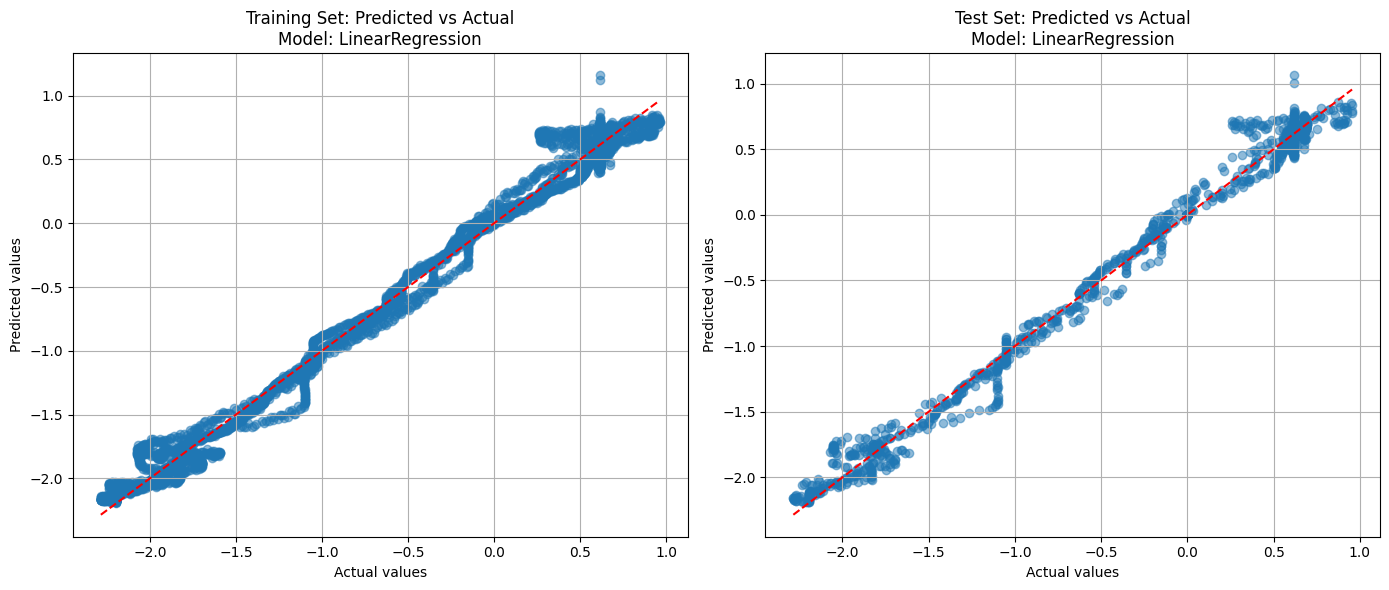

In [ ]:
# Start time
start_time = time.time()

# Create polynomial features
poly_features = PolynomialFeatures(degree=5)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Train polynomial regression model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Make predictions
y_train_pred_poly = poly_reg.predict(X_train_poly)
y_test_pred_poly = poly_reg.predict(X_test_poly)

# End time
end_time = time.time()
# Print training time
print(f"\nTraining time: {end_time - start_time} seconds")

# Evaluate model
print("Polynomial Regression:")
print("\n")
print_evaluation_metrics(y_train, y_train_pred_poly, poly_reg)
print("\n")
print_evaluation_metrics(y_test, y_test_pred_poly, poly_reg)

# Plot predictions
plot_predictions(y_train, y_train_pred_poly, y_test, y_test_pred_poly, poly_reg)

## **RandomizedSearchCV + KFold**

In [ ]:
# Define the polynomial regression pipeline
polynomial_regression = Pipeline([
    ('polynomial_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Define the parameter grid for polynomial regression
polynomial_param_grid = {
    'polynomial_features__degree': [2, 3, 4],  # Try different degrees for polynomial features
    'polynomial_features__interaction_only': [True, False],  # Whether to include only interaction features
    'polynomial_features__include_bias': [True, False]  # Whether to include a bias column in the features
}

# Define the number of iterations for the randomized search
n_iter_search = 10  # Adjust this based on computational resources

# Create a KFold cross-validation iterator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform randomized search and store the best estimator for polynomial regression
print("Searching for best parameters for Polynomial Regression...")
randomized_search_poly = RandomizedSearchCV(
    estimator=polynomial_regression,
    param_distributions=polynomial_param_grid,
    n_iter=n_iter_search,
    scoring='r2',  # Use appropriate scoring metric
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)

randomized_search_poly.fit(X_train, y_train)
best_poly_estimator = randomized_search_poly.best_estimator_

print("Best parameters found for Polynomial Regression:")
print(randomized_search_poly.best_params_)
print("-----------------------------------------------")
for model_name, best_estimator in best_estimators.items():
    print(f"Evaluating model: {model_name}")
    y_train_pred = best_estimator.predict(X_train)
    y_test_pred = best_estimator.predict(X_test)

    # Print evaluation metrics for training set
    print("Training Set Evaluation Metrics:")
    print_evaluation_metrics(y_train, y_train_pred, best_estimator)

    # Print evaluation metrics for test set
    print("\nTest Set Evaluation Metrics:")
    print_evaluation_metrics(y_test, y_test_pred, best_estimator)

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_estimator)

Searching for best parameters for Polynomial Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found for Polynomial Regression:
{'polynomial_features__interaction_only': False, 'polynomial_features__include_bias': True, 'polynomial_features__degree': 4}
-----------------------------------------------


NameError: name 'best_estimators' is not defined

## **GridSearchCV + KFold**

Searching for best parameters for Polynomial Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found for Polynomial Regression:
{'polynomial_features__degree': 4, 'polynomial_features__include_bias': True, 'polynomial_features__interaction_only': False}
-----------------------------------------------
Training Set Evaluation Metrics for Polynomial Regression:
Model: Pipeline
Mean Squared Error (MSE): 1.8980300303113754e-06
Mean Absolute Error (MAE): 0.00036694407110035186
Root Mean Squared Error (RMSE): 0.0013776901067770557
R-squared (R2): 0.9583379371237586
Adjusted R-squared (Adjusted R2): 0.9583161757955391

Test Set Evaluation Metrics for Polynomial Regression:
Model: Pipeline
Mean Squared Error (MSE): 1.7742563310373954e-06
Mean Absolute Error (MAE): 0.00034931142820338073
Root Mean Squared Error (RMSE): 0.0013320121362200104
R-squared (R2): 0.9593515467479133
Adjusted R-squared (Adjusted R2): 0.9592665081427835


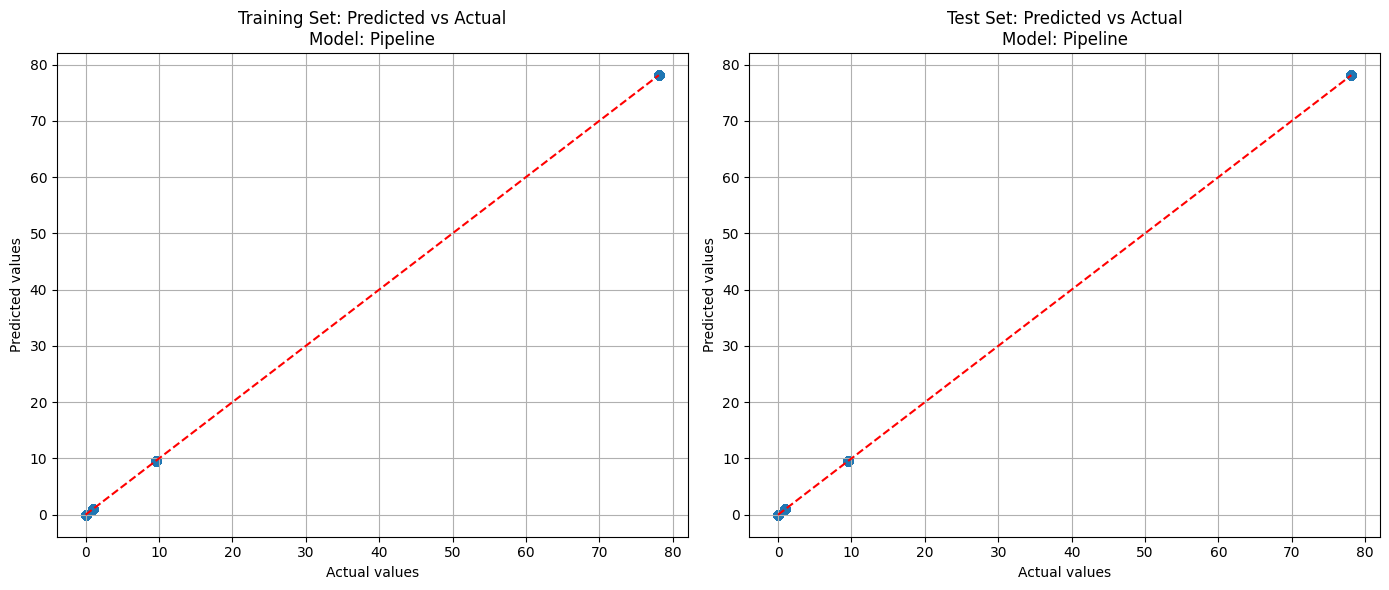

In [ ]:
# Define the polynomial regression pipeline
polynomial_regression = Pipeline([
    ('polynomial_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Define the parameter grid for polynomial regression
polynomial_param_grid = {
    'polynomial_features__degree': [2, 3, 4],  # Try different degrees for polynomial features
    'polynomial_features__interaction_only': [True, False],  # Whether to include only interaction features
    'polynomial_features__include_bias': [True, False]  # Whether to include a bias column in the features
}

# Create a KFold cross-validation iterator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search and store the best estimator for polynomial regression
print("Searching for best parameters for Polynomial Regression...")
grid_search_poly = GridSearchCV(
    estimator=polynomial_regression,
    param_grid=polynomial_param_grid,
    scoring='r2',  # Use appropriate scoring metric
    cv=kf,
    verbose=2,
    n_jobs=-1  # Utilize all available CPU cores
)

grid_search_poly.fit(X_train, y_train)
best_poly_estimator = grid_search_poly.best_estimator_

print("Best parameters found for Polynomial Regression:")
print(grid_search_poly.best_params_)
print("-----------------------------------------------")

# Now you can evaluate the best polynomial regression model
y_train_pred_poly = best_poly_estimator.predict(X_train)
y_test_pred_poly = best_poly_estimator.predict(X_test)

# Print evaluation metrics for training set
print("Training Set Evaluation Metrics for Polynomial Regression:")
print_evaluation_metrics(y_train, y_train_pred_poly, best_poly_estimator)

# Print evaluation metrics for test set
print("\nTest Set Evaluation Metrics for Polynomial Regression:")
print_evaluation_metrics(y_test, y_test_pred_poly, best_poly_estimator)

# Plot predictions for polynomial regression
plot_predictions(y_train, y_train_pred_poly, y_test, y_test_pred_poly, best_poly_estimator)


## **GridSearchCV + ShuffleSplit**

Searching for best parameters for Polynomial Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found for Polynomial Regression:
{'polynomial_features__degree': 40, 'polynomial_features__include_bias': True, 'polynomial_features__interaction_only': False}
-----------------------------------------------
Training Set Evaluation Metrics for Polynomial Regression:
Model: Pipeline
Mean Squared Error (MSE): 1.7398837449664196e-08
Mean Absolute Error (MAE): 3.642300130993914e-05
Root Mean Squared Error (RMSE): 0.00013190465287344564
R-squared (R2): 0.9993211665107017
Adjusted R-squared (Adjusted R2): 0.9993208119358835

Test Set Evaluation Metrics for Polynomial Regression:
Model: Pipeline
Mean Squared Error (MSE): 1.7251286127551934e-08
Mean Absolute Error (MAE): 3.698157021489879e-05
Root Mean Squared Error (RMSE): 0.0001313441514782898
R-squared (R2): 0.9992718353078621
Adjusted R-squared (Adjusted R2): 0.9992703119507655


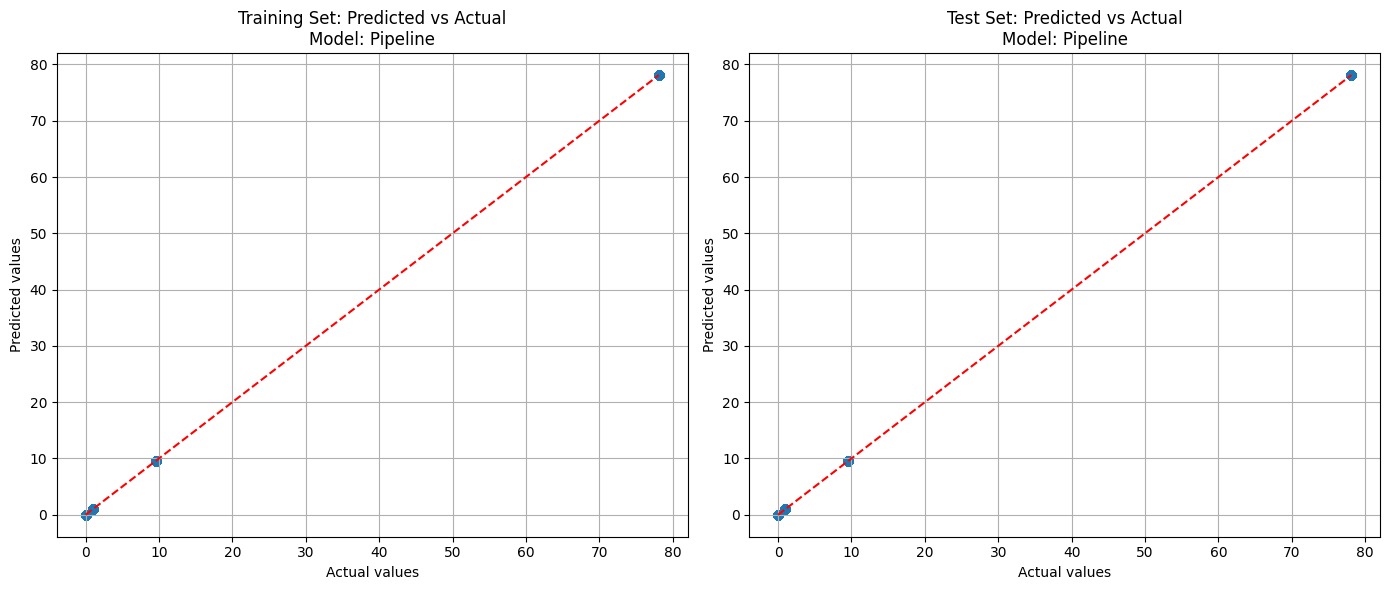

In [ ]:
# Define the polynomial regression pipeline
polynomial_regression = Pipeline([
    ('polynomial_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Define the parameter grid for polynomial regression
polynomial_param_grid = {
    'polynomial_features__degree': [2, 3, 4,40],  # Try different degrees for polynomial features
    'polynomial_features__interaction_only': [True, False],  # Whether to include only interaction features
    'polynomial_features__include_bias': [True, False]  # Whether to include a bias column in the features
}

# Create a ShuffleSplit cross-validation iterator
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform grid search and store the best estimator for polynomial regression
print("Searching for best parameters for Polynomial Regression...")
grid_search_poly = GridSearchCV(
    estimator=polynomial_regression,
    param_grid=polynomial_param_grid,
    scoring='r2',  # Use appropriate scoring metric
    cv=shuffle_split,
    verbose=2,
    n_jobs=-1  # Utilize all available CPU cores
)

grid_search_poly.fit(X_train, y_train)
best_poly_estimator = grid_search_poly.best_estimator_

print("Best parameters found for Polynomial Regression:")
print(grid_search_poly.best_params_)
print("-----------------------------------------------")

# Now you can evaluate the best polynomial regression model
y_train_pred_poly = best_poly_estimator.predict(X_train)
y_test_pred_poly = best_poly_estimator.predict(X_test)

# Print evaluation metrics for training set
print("Training Set Evaluation Metrics for Polynomial Regression:")
print_evaluation_metrics(y_train, y_train_pred_poly, best_poly_estimator)

# Print evaluation metrics for test set
print("\nTest Set Evaluation Metrics for Polynomial Regression:")
print_evaluation_metrics(y_test, y_test_pred_poly, best_poly_estimator)

# Plot predictions for polynomial regression
plot_predictions(y_train, y_train_pred_poly, y_test, y_test_pred_poly, best_poly_estimator)


## **RandomizedSearchCV + ShuffleSplit**

In [ ]:


# Define the polynomial regression pipeline
polynomial_regression = Pipeline([
    ('polynomial_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Define the parameter grid for polynomial regression
polynomial_param_grid = {
    'polynomial_features__degree': [20, 30, 40,100],  # Try different degrees for polynomial features
    'polynomial_features__interaction_only': [True, False],  # Whether to include only interaction features
    'polynomial_features__include_bias': [True, False]  # Whether to include a bias column in the features
}

# Define the number of iterations for the randomized search
n_iter_search = 10  # Adjust this based on computational resources

# Create a ShuffleSplit cross-validation iterator
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform randomized search and store the best estimator for polynomial regression
print("Searching for best parameters for Polynomial Regression with ShuffleSplit...")
randomized_search_poly = RandomizedSearchCV(
    estimator=polynomial_regression,
    param_distributions=polynomial_param_grid,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',  # Use appropriate scoring metric
    cv=shuffle_split,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)

randomized_search_poly.fit(X_train, y_train)
best_poly_estimator = randomized_search_poly.best_estimator_

print("Best parameters found for Polynomial Regression:")
print(randomized_search_poly.best_params_)
print("-----------------------------------------------")

# Now you can evaluate the best polynomial regression model
y_train_pred_poly = best_poly_estimator.predict(X_train)
y_test_pred_poly = best_poly_estimator.predict(X_test)

# Print evaluation metrics for training set
print("Training Set Evaluation Metrics for Polynomial Regression:")
print_evaluation_metrics(y_train, y_train_pred_poly, best_poly_estimator)

# Print evaluation metrics for test set
print("\nTest Set Evaluation Metrics for Polynomial Regression:")
print_evaluation_metrics(y_test, y_test_pred_poly, best_poly_estimator)

# Plot predictions for polynomial regression
plot_predictions(y_train, y_train_pred_poly, y_test, y_test_pred_poly, best_poly_estimator)


## **BayesSeacrhCV + Kfold**

In [ ]:
# Define the polynomial regression pipeline
polynomial_regression = Pipeline([
    ('polynomial_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Define the parameter grid for polynomial regression
polynomial_param_grid = {
    'polynomial_features__degree': (2, 4),  # Integer range between 2 and 4
    'polynomial_features__interaction_only': [True, False],  # Boolean choice
    'polynomial_features__include_bias': [True, False]  # Boolean choice
}

# Define the number of iterations for the Bayesian search
n_iter_search = 10  # You can adjust this number based on your computational resources

# Create a KFold cross-validation iterator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Bayesian search and store the best estimator for polynomial regression
print("Searching for best parameters for Polynomial Regression...")
bayesian_search_poly = BayesSearchCV(
    estimator=polynomial_regression,
    search_spaces=polynomial_param_grid,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',  # Use appropriate scoring metric
    cv=kf,
    verbose=3,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)

bayesian_search_poly.fit(X_train, y_train)
best_poly_estimator = bayesian_search_poly.best_estimator_

print("Best parameters found for Polynomial Regression:")
print(bayesian_search_poly.best_params_)
print("-----------------------------------------------")

# Evaluate the best estimator
y_train_pred = best_poly_estimator.predict(X_train)
y_test_pred = best_poly_estimator.predict(X_test)

# Print evaluation metrics for training set
print("Training Set Evaluation Metrics:")
print_evaluation_metrics(y_train, y_train_pred, best_poly_estimator)

# Print evaluation metrics for test set
print("\nTest Set Evaluation Metrics:")
print_evaluation_metrics(y_test, y_test_pred, best_poly_estimator)

# Plot predictions
plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_poly_estimator)

## **BayesSearchCV + ShuffleSplit**

In [ ]:
# Define the polynomial regression pipeline
polynomial_regression = Pipeline([
    ('polynomial_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Define the parameter grid for polynomial regression
polynomial_param_grid = {
    'polynomial_features__degree': (2, 4),  # Integer range between 2 and 4
    'polynomial_features__interaction_only': [True, False],  # Boolean choice
    'polynomial_features__include_bias': [True, False]  # Boolean choice
}

# Define the number of iterations for the Bayesian search
n_iter_search = 10  # You can adjust this number based on your computational resources

# Create a ShuffleSplit cross-validation iterator
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform Bayesian search and store the best estimator for polynomial regression
print("Searching for best parameters for Polynomial Regression...")
bayesian_search_poly = BayesSearchCV(
    estimator=polynomial_regression,
    search_spaces=polynomial_param_grid,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',  # Use appropriate scoring metric
    cv=shuffle_split,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)

bayesian_search_poly.fit(X_train, y_train)
best_poly_estimator = bayesian_search_poly.best_estimator_

print("Best parameters found for Polynomial Regression:")
print(bayesian_search_poly.best_params_)
print("-----------------------------------------------")

# Evaluate the best estimator
y_train_pred = best_poly_estimator.predict(X_train)
y_test_pred = best_poly_estimator.predict(X_test)

# Print evaluation metrics for training set
print("Training Set Evaluation Metrics:")
print_evaluation_metrics(y_train, y_train_pred, best_poly_estimator)

# Print evaluation metrics for test set
print("\nTest Set Evaluation Metrics:")
print_evaluation_metrics(y_test, y_test_pred, best_poly_estimator)

# Plot predictions
plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_poly_estimator)

# **Step 2 - Random Forest Regressor Models**

## **Base model**


Training time: 3.0238144397735596 seconds
Random Forest Regressor:

Training data
Model: RandomForestRegressor
Mean Squared Error (MSE): 1.7254888698242873e-07
Mean Absolute Error (MAE): 0.00010563472591586729
Root Mean Squared Error (RMSE): 0.00041539004198756226
R-squared (R2): 0.9999998274511129
Adjusted R-squared (Adjusted R2): 0.9999998273609856

Testing data
Model: RandomForestRegressor
Mean Squared Error (MSE): 1.0299134274991442e-06
Mean Absolute Error (MAE): 0.00025831598588195
Root Mean Squared Error (RMSE): 0.0010148465044030768
R-squared (R2): 0.9999988977384823
Adjusted R-squared (Adjusted R2): 0.9999988954324959


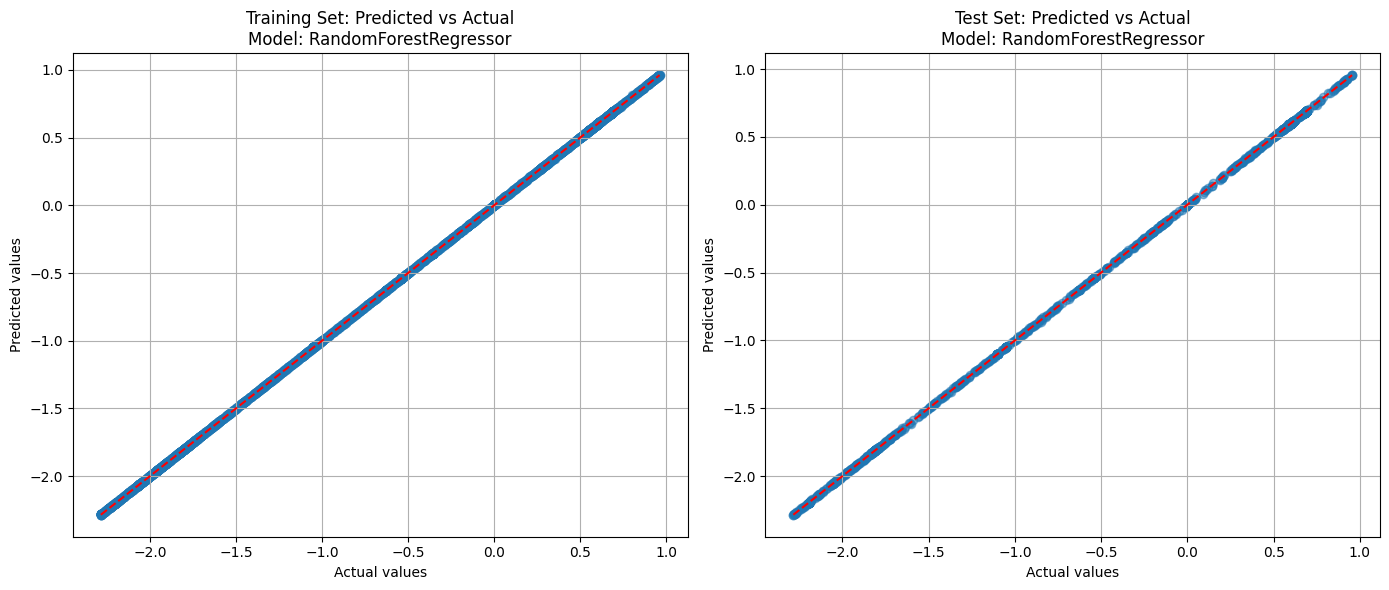

In [ ]:
# Start time
start_time = time.time()

# Train Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_reg.predict(X_train)
y_test_pred_rf = rf_reg.predict(X_test)

"""print("\nTrain given data")
print(X_train)
print("\nTrain output predicted data")
print(y_test_pred_rf)
print("\nTrain output  data")
print(y_train)

print("\nTest")
print("\nTest given data")
print(X_test)
print("\nTest output predicted data")
print(y_test_pred_rf)
print("\nTest output  data")
print(y_test)"""

# End time
end_time = time.time()

# Print training time
print(f"\nTraining time: {end_time - start_time} seconds")

# Evaluate model
print("Random Forest Regressor:")
print("\nTraining data")
print_evaluation_metrics(y_train, y_train_pred_rf,rf_reg)
print("\nTesting data")
print_evaluation_metrics(y_test, y_test_pred_rf,rf_reg)

# Plot predictions
plot_predictions(y_train, y_train_pred_rf, y_test, y_test_pred_rf, rf_reg)

## ****RandomizedSearchCV + Shufflesplit****

In [ ]:
# Define the models dictionary and param_grids
models = {
    'Random Forest': RandomForestRegressor(random_state=42)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'bootstrap': [True, False],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'max_leaf_nodes': [None, 10, 20, 30],
        'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'],
    }
}

# Define the number of iterations for the randomized search
n_iter_search = 10  # You can adjust this number based on your computational resources

# Create a ShuffleSplit cross-validation iterator
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform randomized search and store the best estimator for each model
best_estimators = {}

for model_name, model in models.items():
    print(f"Searching for best parameters for {model_name}...")
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=n_iter_search,
        scoring='neg_mean_squared_error',  # Use appropriate scoring metric
        cv=cv,
        verbose=2,
        random_state=42,
        n_jobs=-1  # Utilize all available CPU cores
    )

    randomized_search.fit(X_train, y_train)
    best_estimators[model_name] = randomized_search.best_estimator_

    print(f"Best parameters found for {model_name}:")
    print(randomized_search.best_params_)
    print("-----------------------------------------------")

Searching for best parameters for Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found for Random Forest:
{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'absolute_error', 'bootstrap': False}
-----------------------------------------------


Evaluating model: Random Forest
Training Set Evaluation Metrics:
Model: RandomForestRegressor
Mean Squared Error (MSE): 1.4444483571883722e-09
Mean Absolute Error (MAE): 4.351485715909373e-06
Root Mean Squared Error (RMSE): 3.800589897882133e-05
R-squared (R2): 0.9999623778137728
Adjusted R-squared (Adjusted R2): 0.9999623476798631

Test Set Evaluation Metrics:
Model: RandomForestRegressor
Mean Squared Error (MSE): 2.06898299947554e-09
Mean Absolute Error (MAE): 5.650715032147153e-06
Root Mean Squared Error (RMSE): 4.548607478641722e-05
R-squared (R2): 0.9999437083426039
Adjusted R-squared (Adjusted R2): 0.9999435905776303


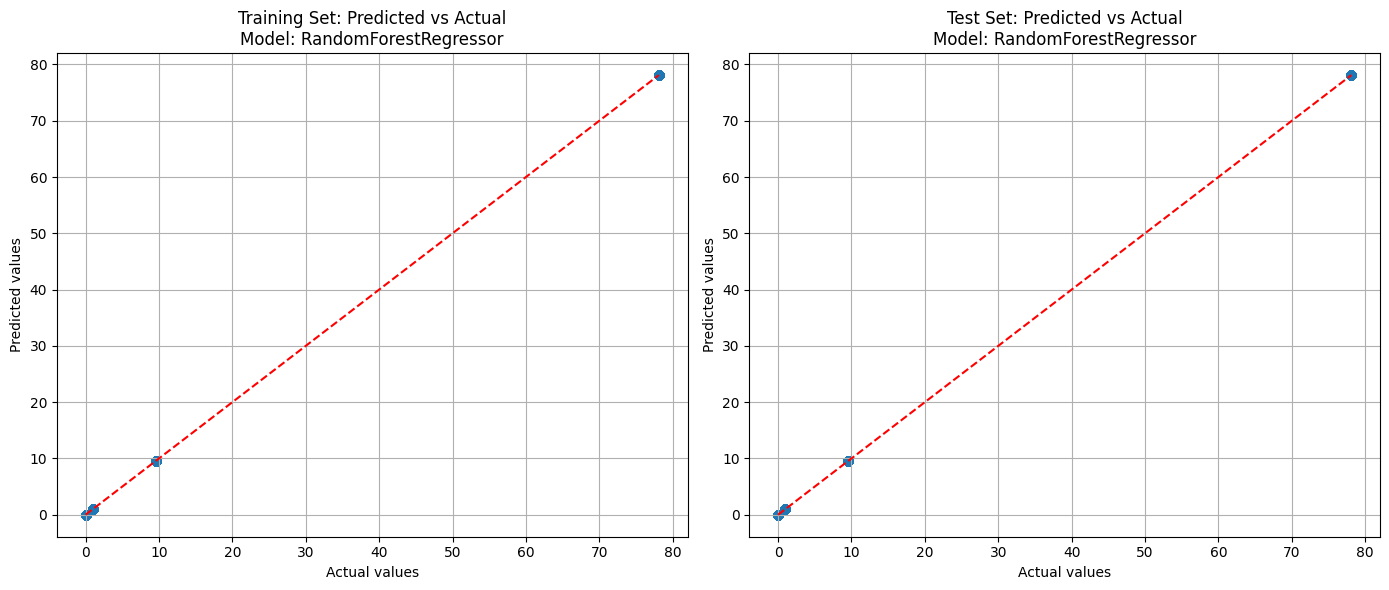

In [ ]:
# After the loop where you find the best estimators
for model_name, best_estimator in best_estimators.items():
    print(f"Evaluating model: {model_name}")
    y_train_pred = best_estimator.predict(X_train)
    y_test_pred = best_estimator.predict(X_test)

    # Print evaluation metrics for training set
    print("Training Set Evaluation Metrics:")
    print_evaluation_metrics(y_train, y_train_pred, best_estimator)

    # Print evaluation metrics for test set
    print("\nTest Set Evaluation Metrics:")
    print_evaluation_metrics(y_test, y_test_pred, best_estimator)

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_estimator)


## **RandomizedSearchCV + KFold**

Searching for best parameters for Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found for Random Forest:
{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'absolute_error', 'bootstrap': False}
-----------------------------------------------
Evaluating model: Random Forest
Training Set Evaluation Metrics:
Model: RandomForestRegressor
Mean Squared Error (MSE): 1.4444483571883722e-09
Mean Absolute Error (MAE): 4.351485715909373e-06
Root Mean Squared Error (RMSE): 3.800589897882133e-05
R-squared (R2): 0.9999623778137728
Adjusted R-squared (Adjusted R2): 0.9999623476798631

Test Set Evaluation Metrics:
Model: RandomForestRegressor
Mean Squared Error (MSE): 2.06898299947554e-09
Mean Absolute Error (MAE): 5.650715032147153e-06
Root Mean Squared Error (RMSE): 4.548607478641722e-05
R-squared (R2): 0.9999437083426039
Adjuste

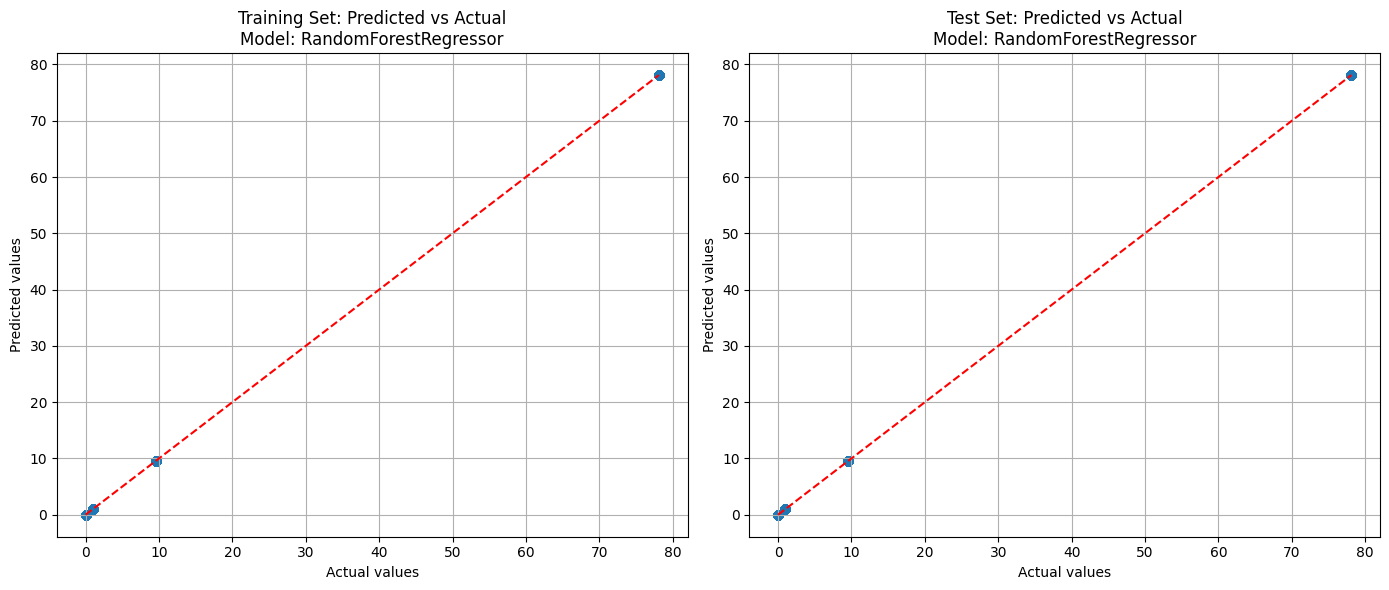

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold

# Assuming X_train and y_train are your training data and labels

# Define the models dictionary and param_grids
models = {
    'Random Forest': RandomForestRegressor(random_state=42)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'bootstrap': [True, False],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'max_leaf_nodes': [None, 10, 20, 30],
        'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'],
    }
}

# Define the number of iterations for the randomized search
n_iter_search = 10  # You can adjust this number based on your computational resources

# Create a KFold cross-validation iterator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform randomized search and store the best estimator for each model
best_estimators = {}

for model_name, model in models.items():
    print(f"Searching for best parameters for {model_name}...")
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=n_iter_search,
        scoring='neg_mean_squared_error',  # Use appropriate scoring metric
        cv=kf,
        verbose=2,
        random_state=42,
        n_jobs=-1  # Utilize all available CPU cores
    )

    randomized_search.fit(X_train, y_train)
    best_estimators[model_name] = randomized_search.best_estimator_

    print(f"Best parameters found for {model_name}:")
    print(randomized_search.best_params_)
    print("-----------------------------------------------")

# Now you can access the best estimators using best_estimators dictionary
# For example:
# best_rf_estimator = best_estimators['Random Forest']
# After the loop where you find the best estimators
for model_name, best_estimator in best_estimators.items():
    print(f"Evaluating model: {model_name}")
    y_train_pred = best_estimator.predict(X_train)
    y_test_pred = best_estimator.predict(X_test)

    # Print evaluation metrics for training set
    print("Training Set Evaluation Metrics:")
    print_evaluation_metrics(y_train, y_train_pred, best_estimator)

    # Print evaluation metrics for test set
    print("\nTest Set Evaluation Metrics:")
    print_evaluation_metrics(y_test, y_test_pred, best_estimator)

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_estimator)


## **GridSearchCV + ShuffleSplit**

Searching for best parameters for Random Forest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found for Random Forest:
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
-----------------------------------------------
Evaluating model: Random Forest
Training Set Evaluation Metrics:
Model: RandomForestRegressor
Mean Squared Error (MSE): 6.267883324119765e-12
Mean Absolute Error (MAE): 6.235568153369441e-07
Root Mean Squared Error (RMSE): 2.5035741099715354e-06
R-squared (R2): 0.9999997502235062
Adjusted R-squared (Adjusted R2): 0.9999997500930405

Test Set Evaluation Metrics:
Model: RandomForestRegressor
Mean Squared Error (MSE): 2.29076754053058e-11
Mean Absolute Error (MAE): 1.0827762308067195e-06
Root Mean Squared Error (RMSE): 4.786196340028875e-06
R-squared (R2): 0.9999990948838856
Adjuste

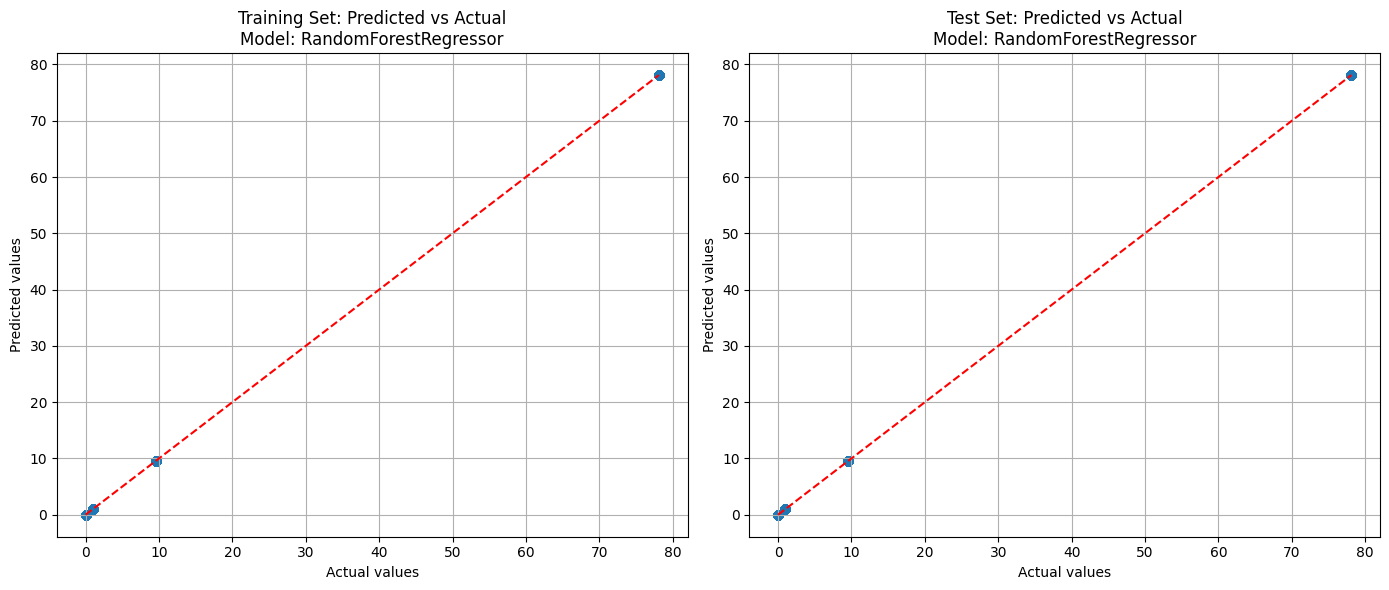

In [ ]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit

# Assuming X_train and y_train are your training data and labels

# Define the models dictionary and param_grids
models = {
    'Random Forest': RandomForestRegressor(random_state=42)
}
"""
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'bootstrap': [True, False],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'max_leaf_nodes': [None, 10, 20, 30],
        'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'],
    }
}"""
"""
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],  # Reduced to 2 values
        'max_depth': [None, 20, 30],  # Reduced to 3 values
        'min_samples_split': [2, 10],  # Reduced to 2 values
        'min_samples_leaf': [1, 4],  # Reduced to 2 values
        'bootstrap': [True, False],  # Kept as 2 values
        'max_features': ['auto', 'sqrt'],  # Reduced to 2 values
        'min_impurity_decrease': [0.0, 0.1],  # Reduced to 2 values
        'max_leaf_nodes': [None, 20],  # Reduced to 2 values
        'criterion': ['squared_error', 'absolute_error'],  # Reduced to 2 values
    }
}"""

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],  # Kept as 2 values
        'max_depth': [20, 30],  # Reduced to 2 values
        'min_samples_split': [2, 10],  # Kept as 2 values
        'min_samples_leaf': [1, 4],  # Kept as 2 values
        'bootstrap': [True],  # Reduced to 1 value
        'max_features': ['sqrt'],  # Reduced to 1 value
        'min_impurity_decrease': [0.0],  # Reduced to 1 value
        'max_leaf_nodes': [None],  # Reduced to 1 value
        'criterion': ['squared_error']  # Reduced to 1 value
    }
}



# Create a ShuffleSplit cross-validation iterator
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform GridSearchCV and store the best estimator for each model
best_estimators = {}

for model_name, model in models.items():
    print(f"Searching for best parameters for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='neg_mean_squared_error',  # Use appropriate scoring metric
        cv=cv,
        verbose=2,
        n_jobs=-1  # Utilize all available CPU cores
    )

    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_

    print(f"Best parameters found for {model_name}:")
    print(grid_search.best_params_)
    print("-----------------------------------------------")

# Now you can access the best estimators using best_estimators dictionary
# For example:
# best_rf_estimator = best_estimators['Random Forest']
# After the loop where you find the best estimators
for model_name, best_estimator in best_estimators.items():
    print(f"Evaluating model: {model_name}")
    y_train_pred = best_estimator.predict(X_train)
    y_test_pred = best_estimator.predict(X_test)

    # Print evaluation metrics for training set
    print("Training Set Evaluation Metrics:")
    print_evaluation_metrics(y_train, y_train_pred, best_estimator)

    # Print evaluation metrics for test set
    print("\nTest Set Evaluation Metrics:")
    print_evaluation_metrics(y_test, y_test_pred, best_estimator)

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_estimator)


## **GridSearchCV + KFold**

Searching for best parameters for Random Forest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found for Random Forest:
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
-----------------------------------------------
Evaluating model: Random Forest
Training Set Evaluation Metrics:
Model: RandomForestRegressor
Mean Squared Error (MSE): 6.267883324119765e-12
Mean Absolute Error (MAE): 6.235568153369441e-07
Root Mean Squared Error (RMSE): 2.5035741099715354e-06
R-squared (R2): 0.9999997502235062
Adjusted R-squared (Adjusted R2): 0.9999997500930405

Test Set Evaluation Metrics:
Model: RandomForestRegressor
Mean Squared Error (MSE): 2.29076754053058e-11
Mean Absolute Error (MAE): 1.0827762308067195e-06
Root Mean Squared Error (RMSE): 4.786196340028875e-06
R-squared (R2): 0.9999990948838856
Adjuste

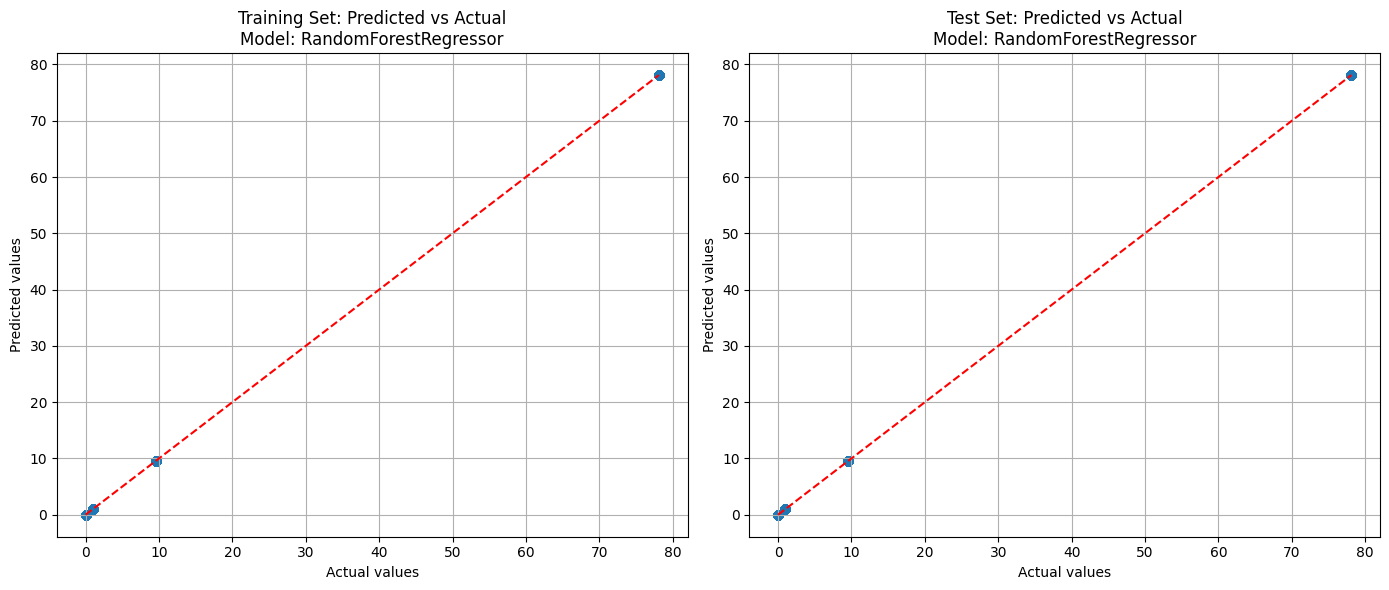

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

# Assuming X_train and y_train are your training data and labels

# Define the models dictionary and param_grids
models = {
    'Random Forest': RandomForestRegressor(random_state=42)
}
"""
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'bootstrap': [True, False],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'max_leaf_nodes': [None, 10, 20, 30],
        'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'],
    }
}"""

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],  # Kept as 2 values
        'max_depth': [20, 30],  # Reduced to 2 values
        'min_samples_split': [2, 10],  # Kept as 2 values
        'min_samples_leaf': [1, 4],  # Kept as 2 values
        'bootstrap': [True],  # Reduced to 1 value
        'max_features': ['sqrt'],  # Reduced to 1 value
        'min_impurity_decrease': [0.0],  # Reduced to 1 value
        'max_leaf_nodes': [None],  # Reduced to 1 value
        'criterion': ['squared_error']  # Reduced to 1 value
    }
}

# Create a KFold cross-validation iterator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV and store the best estimator for each model
best_estimators = {}

for model_name, model in models.items():
    print(f"Searching for best parameters for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='neg_mean_squared_error',  # Use appropriate scoring metric
        cv=kf,
        verbose=2,
        n_jobs=-1  # Utilize all available CPU cores
    )

    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_

    print(f"Best parameters found for {model_name}:")
    print(grid_search.best_params_)
    print("-----------------------------------------------")

# Now you can access the best estimators using best_estimators dictionary
# For example:
# best_rf_estimator = best_estimators['Random Forest']
# After the loop where you find the best estimators
for model_name, best_estimator in best_estimators.items():
    print(f"Evaluating model: {model_name}")
    y_train_pred = best_estimator.predict(X_train)
    y_test_pred = best_estimator.predict(X_test)

    # Print evaluation metrics for training set
    print("Training Set Evaluation Metrics:")
    print_evaluation_metrics(y_train, y_train_pred, best_estimator)

    # Print evaluation metrics for test set
    print("\nTest Set Evaluation Metrics:")
    print_evaluation_metrics(y_test, y_test_pred, best_estimator)

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_estimator)


## **BayesSearchCV + KFold**

Searching for best parameters for Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found for Random Forest:
OrderedDict([('bootstrap', True), ('criterion', 'poisson'), ('max_depth', 23), ('max_features', 'sqrt'), ('max_leaf_nodes', 33), ('min_impurity_decrease', 0.054942969767083495), ('min_samples_leaf', 3), ('min_samples_split', 5), ('n_estimators', 184)])
-----------------------------------------------
Evaluating model:

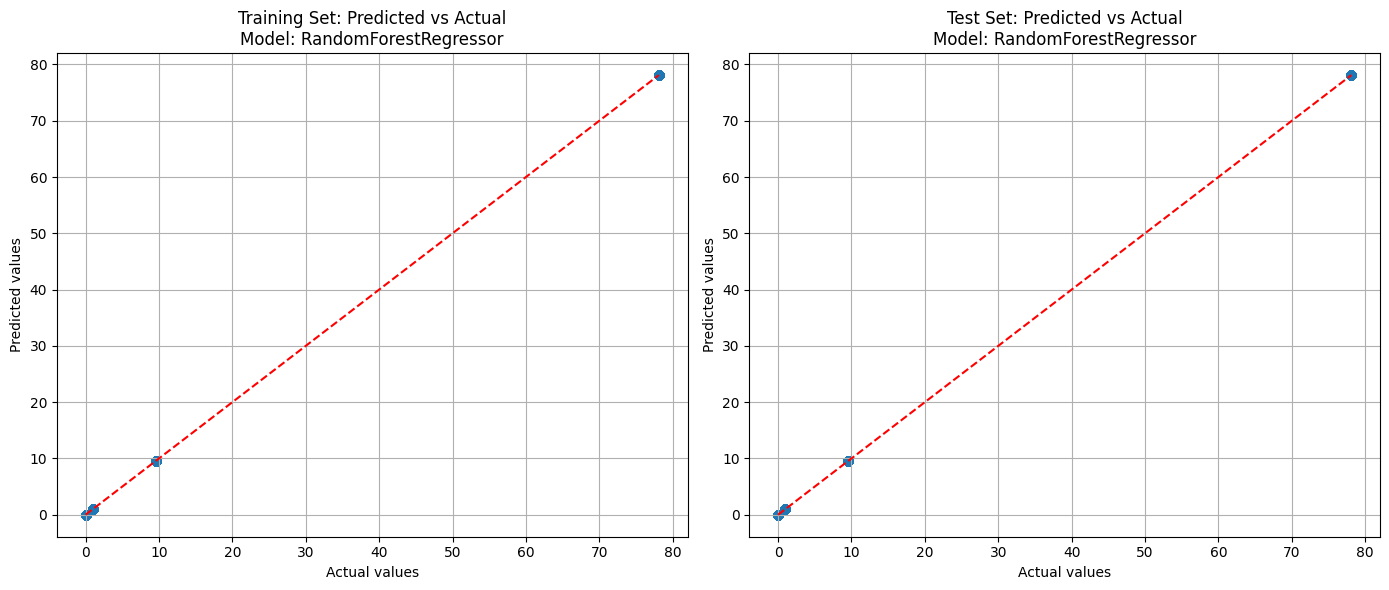

In [ ]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold

# Assuming X_train and y_train are your training data and labels

# Define the models dictionary and param_grids
models = {
    'Random Forest': RandomForestRegressor(random_state=42)
}

"""
param_grids = {
    'Random Forest': {
        'n_estimators': (50, 200),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 8),
        'bootstrap': [True, False],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'min_impurity_decrease': (0.0, 0.2),
        'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'],
    }
}
"""

param_grids = {
    'Random Forest': {
        'n_estimators': (50, 200),  # Integer range between 50 and 200
        'max_depth': (3, 30),  # Integer range between 3 and 30
        'min_samples_split': (2, 20),  # Integer range between 2 and 20
        'min_samples_leaf': (1, 8),  # Integer range between 1 and 8
        'bootstrap': [True, False],  # Boolean choice
        'max_features': ['auto', 'sqrt', 'log2', None],  # Categorical choice
        'min_impurity_decrease': (0.0, 0.2),  # Float range between 0.0 and 0.2
        'max_leaf_nodes': (10, 50),  # Integer range between 10 and 50
        'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'],  # Categorical choice
    }
}



# Define the number of iterations for the Bayesian search
n_iter_search = 10  # You can adjust this number based on your computational resources

# Create a KFold cross-validation iterator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Bayesian search and store the best estimator for each model
best_estimators = {}

for model_name, model in models.items():
    print(f"Searching for best parameters for {model_name}...")
    bayesian_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_grids[model_name],
        n_iter=n_iter_search,
        scoring='neg_mean_squared_error',  # Use appropriate scoring metric
        cv=kf,
        verbose=2,
        random_state=42,
        n_jobs=-1  # Utilize all available CPU cores
    )

    bayesian_search.fit(X_train, y_train)
    best_estimators[model_name] = bayesian_search.best_estimator_

    print(f"Best parameters found for {model_name}:")
    print(bayesian_search.best_params_)
    print("-----------------------------------------------")

# Now you can access the best estimators using best_estimators dictionary
# For example:
# best_rf_estimator = best_estimators['Random Forest']
# After the loop where you find the best estimators
for model_name, best_estimator in best_estimators.items():
    print(f"Evaluating model: {model_name}")
    y_train_pred = best_estimator.predict(X_train)
    y_test_pred = best_estimator.predict(X_test)

    # Print evaluation metrics for training set
    print("Training Set Evaluation Metrics:")
    print_evaluation_metrics(y_train, y_train_pred, best_estimator)

    # Print evaluation metrics for test set
    print("\nTest Set Evaluation Metrics:")
    print_evaluation_metrics(y_test, y_test_pred, best_estimator)

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_estimator)


## **BayesSearchCV + Shufflesplit**

Searching for best parameters for Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found for Random Forest:
OrderedDict([('bootstrap', False), ('criterion', 'friedman_mse'), ('max_features', 'log2'), ('min_impurity_decrease', 0.16055295623126212), ('min_samples_leaf', 5), ('min_samples_split', 4), ('n_estimators', 163)])
-----------------------------------------------
Evaluating model: Random Forest
Training Set Evaluation

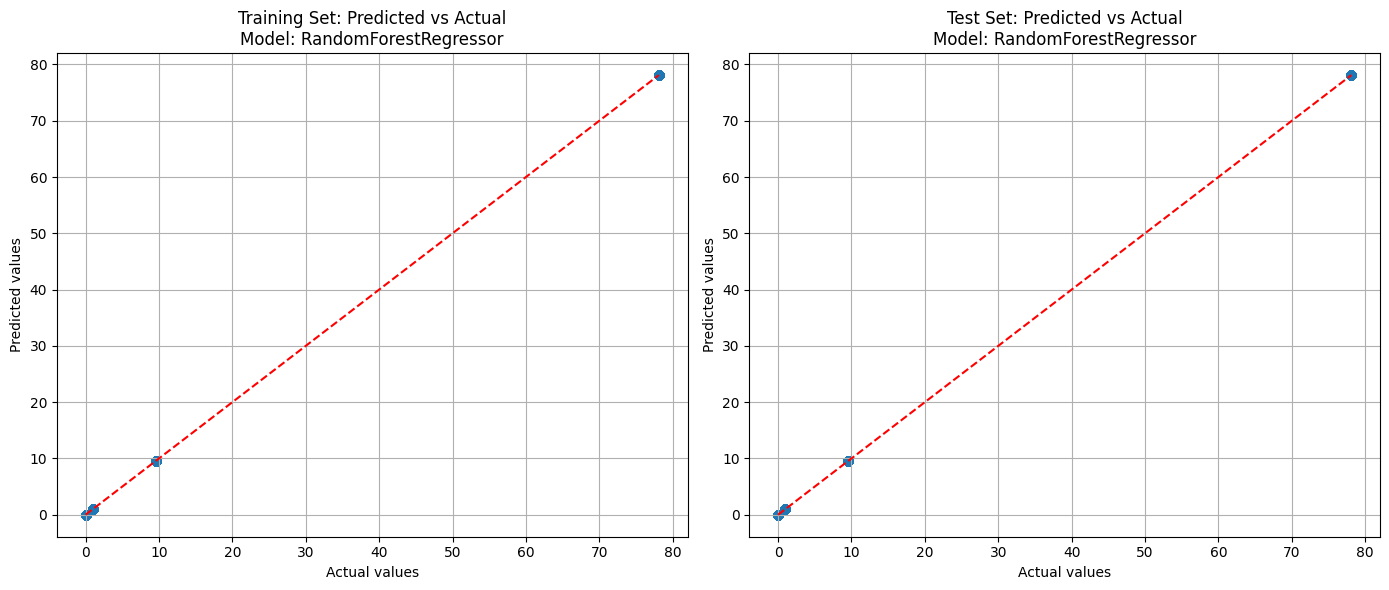

In [ ]:
from skopt import BayesSearchCV
from sklearn.model_selection import ShuffleSplit

# Assuming X_train and y_train are your training data and labels

# Define the models dictionary and param_grids
models = {
    'Random Forest': RandomForestRegressor(random_state=42)
}

param_grids = {
    'Random Forest': {
        'n_estimators': (50, 200),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 8),
        'bootstrap': [True, False],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'min_impurity_decrease': (0.0, 0.2),
        'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'],
    }
}

# Define the number of iterations for the Bayesian search
n_iter_search = 10  # You can adjust this number based on your computational resources

# Create a ShuffleSplit cross-validation iterator
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform Bayesian search and store the best estimator for each model
best_estimators = {}

for model_name, model in models.items():
    print(f"Searching for best parameters for {model_name}...")
    bayesian_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_grids[model_name],
        n_iter=n_iter_search,
        scoring='neg_mean_squared_error',  # Use appropriate scoring metric
        cv=ss,
        verbose=2,
        random_state=42,
        n_jobs=-1  # Utilize all available CPU cores
    )

    bayesian_search.fit(X_train, y_train)
    best_estimators[model_name] = bayesian_search.best_estimator_

    print(f"Best parameters found for {model_name}:")
    print(bayesian_search.best_params_)
    print("-----------------------------------------------")

# Now you can access the best estimators using best_estimators dictionary
# For example:
# best_rf_estimator = best_estimators['Random Forest']
# After the loop where you find the best estimators
for model_name, best_estimator in best_estimators.items():
    print(f"Evaluating model: {model_name}")
    y_train_pred = best_estimator.predict(X_train)
    y_test_pred = best_estimator.predict(X_test)

    # Print evaluation metrics for training set
    print("Training Set Evaluation Metrics:")
    print_evaluation_metrics(y_train, y_train_pred, best_estimator)

    # Print evaluation metrics for test set
    print("\nTest Set Evaluation Metrics:")
    print_evaluation_metrics(y_test, y_test_pred, best_estimator)

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_estimator)


# **Step 2 - XGBoost Regressor Models**

## **Base model**


Training time: 0.16238975524902344 seconds
XGBoost Regressor:


Model: XGBRegressor
Mean Squared Error (MSE): 8.75790190931046e-05
Mean Absolute Error (MAE): 0.002479394815335276
Root Mean Squared Error (RMSE): 0.00935836626196606
R-squared (R2): 0.33324575431424025
Adjusted R-squared (Adjusted R2): 0.3328974888424796


Model: XGBRegressor
Mean Squared Error (MSE): 0.00012600911035881248
Mean Absolute Error (MAE): 0.002970501042417258
Root Mean Squared Error (RMSE): 0.011225377960621749
R-squared (R2): 0.3331982497470402
Adjusted R-squared (Adjusted R2): 0.3318032670059252


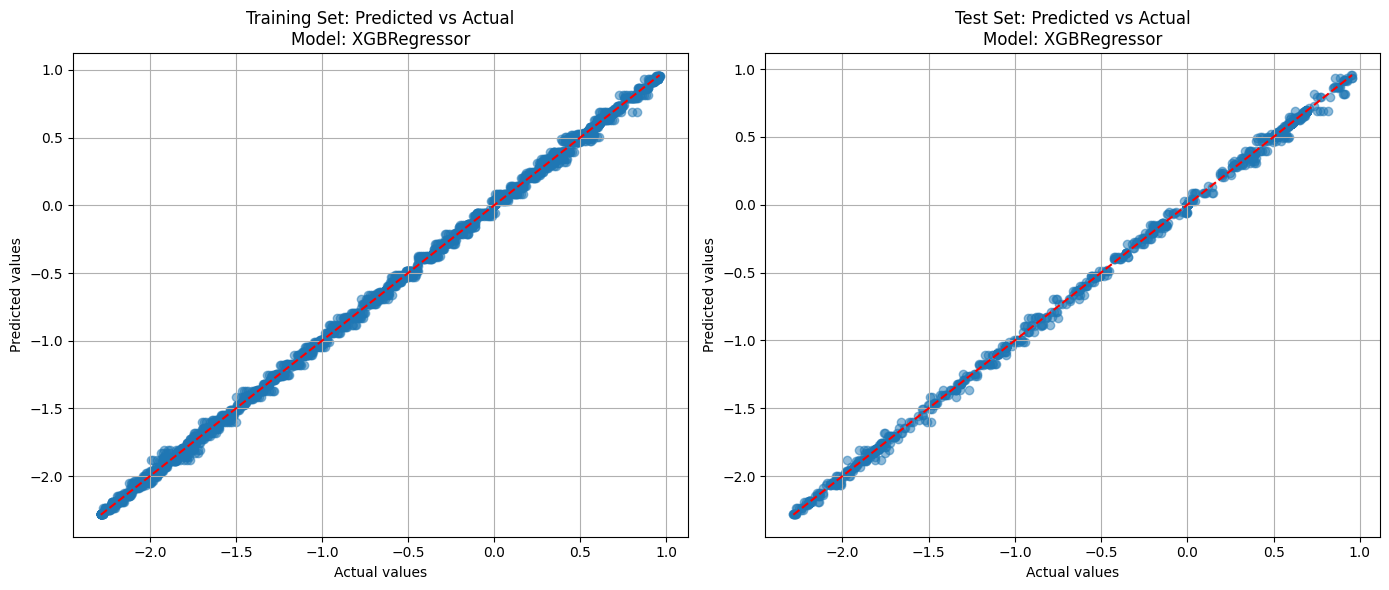

In [ ]:
# Start time
start_time = time.time()
# Train XGBoost Regressor
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Make predictions
y_train_pred_xgb = xgb_reg.predict(X_train)
y_test_pred_xgb = xgb_reg.predict(X_test)

# Start time
end_time = time.time()
# Print training time
print(f"\nTraining time: {end_time - start_time} seconds")

# Evaluate model
print("XGBoost Regressor:")
print("\n")
print_evaluation_metrics(y_train, y_train_pred_xgb, xgb_reg)
print("\n")
print_evaluation_metrics(y_test, y_test_pred_xgb, xgb_reg)

# Plot predictions
plot_predictions(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb, xgb_reg)

## **All 6 model combined**

In [ ]:
# Update the models dictionary
models = {
    'XGBoost': XGBRegressor(random_state=42),
}

# Update the param_grids dictionary
param_grids = {
    'XGBoost': {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    }
}


cv_techniques = {
    'K-Fold': KFold(n_splits=5, shuffle=True, random_state=42),
    'Shuffle Split': ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
}

hyperparameter_methods = {
    'Randomized Search': RandomizedSearchCV,
    'Grid Search': GridSearchCV,
    'Bayesian Search':BayesSearchCV
}

# Results storage
results = []

# Iterate through each model
for model_name, model in models.items():
    # Define parameter grid based on the model
    param_grid = param_grids.get(model_name, {})

    # Iterate through each cross-validation technique
    for cv_name, cv in cv_techniques.items():
        # Iterate through each hyperparameter tuning method
        for hyper_name, hyper_method in hyperparameter_methods.items():
            # Print the current combination being processed
            print(f"Processing: Model - {model_name}, CV Technique - {cv_name}, Hyperparameter Method - {hyper_name}")

            # Measure start time
            start_time = time.time()

            # Perform hyperparameter tuning
            search = hyper_method(model, param_grid, cv=cv, scoring='r2')
            search.fit(X_train, y_train)

            # Measure end time
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Get best parameters and score
            best_params = search.best_params_
            best_score = search.best_score_

            # Store results
            results.append({
                'Model': model_name,
                'CV Technique': cv_name,
                'Hyperparameter Method': hyper_name,
                'Best Params': best_params,
                'Best Score': best_score,
                'Time Taken (s)': elapsed_time
            })

            # Print time taken
            print(f"Time taken: {elapsed_time:.2f} seconds")

            # Print best score
            print(f"Best Score: {best_score}")

            # Print completion message for the current combination
            print(f"Completed processing for: {model_name} - {cv_name} - {hyper_name}\n")

# Find the best overall combination
best_result = max(results, key=lambda x: x['Best Score'])

# Print the best overall combination
print("Best Overall Combination:")
print("Model:", best_result['Model'])
print("CV Technique:", best_result['CV Technique'])
print("Hyperparameter Method:", best_result['Hyperparameter Method'])
print("Best Params:", best_result['Best Params'])
print("Best Score:", best_result['Best Score'])

# Extract best model and parameters
best_model_name = best_result['Model']
best_model = models[best_model_name]
best_params = best_result['Best Params']

# Set up the best model with best hyperparameters
best_model.set_params(**best_params)
best_model.fit(X_train, y_train)

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Print evaluation metrics
print("Training Set Evaluation Metrics:")
print("\n")
print_evaluation_metrics(y_train, y_train_pred, best_model)
print("\n")
print("\nTest Set Evaluation Metrics:")
print_evaluation_metrics(y_test, y_test_pred, best_model)
print("\n")
# Plot predictions
plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_model)

Processing: Model - XGBoost, CV Technique - K-Fold, Hyperparameter Method - Randomized Search
Time taken: 11.11 seconds
Best Score: 0.012703667855721686
Completed processing for: XGBoost - K-Fold - Randomized Search

Processing: Model - XGBoost, CV Technique - K-Fold, Hyperparameter Method - Grid Search


In [ ]:
# Determine the feature shape expected by the XGBoost model
feature_shape = X_train.shape[1]

print("Feature Shape Expected by XGBoost Model:", feature_shape)


In [ ]:
print(X_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# Define XGBoost regressor
xgb_reg = XGBRegressor(random_state=42)

# Define parameters grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate (eta)
    'max_depth': [3, 5, 7],              # Maximum tree depth
    'min_child_weight': [1, 3, 5],       # Minimum child weight
    'subsample': [0.6, 0.8, 1.0],        # Subsample ratio of training instances
    'reg_lambda': [0, 0.1, 1],           # L2 regularization parameter
    'reg_alpha': [0, 0.1, 1]             # L1 regularization parameter
}

# Define scoring function (in this case, mean squared error)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, scoring=scorer, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate best model
y_train_pred_best = best_model.predict(X_train)
y_test_pred_best = best_model.predict(X_test)

# Print best hyperparameters
print("Best Hyperparameters:", best_params)

# Print evaluation metrics of the best model
print("Training Set Evaluation Metrics:")
print_evaluation_metrics(y_train, y_train_pred_best, best_model)
print("\nTest Set Evaluation Metrics:")
print_evaluation_metrics(y_test, y_test_pred_best, best_model)


In [ ]:
# Print evaluation metrics
print("Training Set Evaluation Metrics:")
print_evaluation_metrics(y_train, y_train_pred, best_model)

print("\nTest Set Evaluation Metrics:")
print_evaluation_metrics(y_test, y_test_pred, best_model)

# Plot predictions
plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_model)

In [ ]:
from IPython.display import clear_output
import time

# Print something
print("This will be cleared in 3 seconds")
time.sleep(3)

# Clear the output
clear_output()

# Print something else
print("The previous output has been cleared")


In [ ]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold, ShuffleSplit
import time

# Define K-Fold and Shuffle Split cross-validation techniques
cv_techniques = {
    'K-Fold': KFold(n_splits=5, shuffle=True, random_state=42),
    'Shuffle Split': ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
}

# Define hyperparameter search space for each model
param_grids = {
    'Polynomial Regression': {
        'polynomialfeatures__degree': [2, 3, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Gaussian Process': {
        'kernel': ['rbf', None]
    }
}

# Define hyperparameter tuning methods
hyperparameter_methods = [BayesSearchCV]

# Results storage
results = []

# Iterate through each model
for model_name, model in models.items():
    # Define parameter grid based on the model
    param_grid = param_grids.get(model_name, {})

    # Iterate through each cross-validation technique
    for cv_name, cv in cv_techniques.items():
        # Iterate through each hyperparameter tuning method
        for hyper_method in hyperparameter_methods:
            # Print the current combination being processed
            print(f"Processing: Model - {model_name}, CV Technique - {cv_name}, Hyperparameter Method - {hyper_method.__name__}")

            # Measure start time
            start_time = time.time()

            # Perform hyperparameter tuning
            search = hyper_method(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
            search.fit(X_train, y_train)

            # Measure end time
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Get best parameters and score
            best_params = search.best_params_
            best_score = search.best_score_

            # Store results
            results.append({
                'Model': model_name,
                'CV Technique': cv_name,
                'Hyperparameter Method': hyper_method.__name__,
                'Best Params': best_params,
                'Best Score': best_score,
                'Time Taken (s)': elapsed_time
            })

            # Print completion message for the current combination with time taken
            print(f"Completed processing for: {model_name} - {cv_name} - {hyper_method.__name__}")
            print(f"Time taken: {elapsed_time:.2f} seconds\n")

# Find the best overall combination
best_result = max(results, key=lambda x: x['Best Score'])

# Print the best overall combination
print("Best Overall Combination:")
print("Model:", best_result['Model'])
print("CV Technique:", best_result['CV Technique'])
print("Hyperparameter Method:", best_result['Hyperparameter Method'])
print("Best Params:", best_result['Best Params'])
print("Best Score:", best_result['Best Score'])

# Extract best model and parameters
best_model_name = best_result['Model']
best_model = models[best_model_name]
best_params = best_result['Best Params']

# Set up the best model with best hyperparameters
best_model.set_params(**best_params)
best_model.fit(X_train, y_train)

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [ ]:
# Print evaluation metrics
print("Training Set Evaluation Metrics:")
print_evaluation_metrics(y_train, y_train_pred, best_model)

print("\nTest Set Evaluation Metrics:")
print_evaluation_metrics(y_test, y_test_pred, best_model)

# Plot predictions
plot_predictions(y_train, y_train_pred, y_test, y_test_pred, best_model)

# **Step 3 - New Prediction**

In [ ]:
# Take input from the user for date and time
input_date = input("Enter the date (DD/MM/YYYY): ")
input_time = input("Enter the time (HH:MM:SS): ")

# Check if the input date is in the appropriate format
try:
    input_date = pd.to_datetime(input_date)
except ValueError:
    print("Please enter the date in the format DD/MM/YYYY.")
    exit()

# Check if the input time is in the appropriate format
try:
    input_time = pd.to_datetime(input_time, format='%H:%M:%S').time()
except ValueError:
    print("Please enter the time in the format HH:MM:SS.")
    exit()

# Convert date and time into the required format
input_datetime = pd.to_datetime(str(input_date) + ' ' + str(input_time))
reference_date = pd.to_datetime('2024-01-01')
days_from_ref = (input_datetime - reference_date).days
seconds_from_midnight = input_datetime.hour * 3600 + input_datetime.minute * 60 + input_datetime.second

# Prepare input features for prediction
input_features = np.array([[days_from_ref, seconds_from_midnight]])

# Make prediction using the best model
predicted_coordinates = rf_reg.predict(input_features)

print("Predicted Latitude:", round(predicted_coordinates[0][0], 10))
print("Predicted Longitude:", round(predicted_coordinates[0][1], 10))

Enter the date (DD/MM/YYYY): 20/05/2024
Enter the time (HH:MM:SS): 15:51:00
Predicted Latitude: 9.5703399709
Predicted Longitude: 78.1067810017
